### Used libraries

In [1]:
import pandas as pd
import re
import numpy as np
import folium
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

I've been living in the Ciutat Vella (Old Town) district in **Barcelona** for the past 6 years and I've decided to move to Paris by the end of the year.

**Ciutat Vella** is one of the most traditional districts in **Barcelona** and what makes me like to live here is the diversity of activities that the district offers among museums, restaurants, bars, cafes, galleries and shops. You candefinetly find anything you want in a maximum of 10 or 15 minutes walking.
Even though the acitivities aspect of the district attracts me a lot, I would also consider living in a less dense place with less people living and more open spaces.
So the main question is, using data, how to choose among the 22 districts in **Paris** which one would suite more my needings.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* density of population, number of habitants/m²

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* the surface and number of habitants to get the population density from the <a href="https://es.wikipedia.org/wiki/Distritos_de_Barcelona">Districts of Barcelona Wikipedia page</a> and the <a href="https://es.wikipedia.org/wiki/Distritos_de_Par%C3%ADs">Districts of Paris Wikipedia Page</a>

In [2]:
CLIENT_ID = 'GQT0LGLS4WFIIO3ETSESFILYPJYN2JQ0V1IJFMZ0GO0QEAUC' # your Foursquare ID
CLIENT_SECRET = 'YX20HMLM1LYVNWBI1FQWAUIGOPBLKN4LCWP4U4314OSPXQP3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [3]:
def getNeighborhoodLatLon(neighborhood, city, country):
    address = f"{neighborhood}, {city}, {country}"

    geolocator = Nominatim(user_agent="esplorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    return [latitude, longitude]

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Barcelona

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. 

Let's prepare the data for **Barcelona**.

In [7]:
dfBCN = pd.read_csv('./data/barcelona_districts.csv')
dfBCN['area'] = dfBCN['area'].apply(lambda x: float(x.replace(',', '.')))
dfBCN['population'] = dfBCN['population'].apply(lambda x: float(re.sub(r"\s+", '', x)))
dfBCN['pop_density'] = dfBCN['population']/dfBCN['area']
dfBCN['coord'] = dfBCN['name'].apply(lambda x: getNeighborhoodLatLon(x, 'Barcelona', 'Spain'))
dfBCN['lat'] = dfBCN['coord'].apply(lambda x: x[0])
dfBCN['lon'] = dfBCN['coord'].apply(lambda x: x[1])
dfBCN.head()

,code,name,area,population,pop_density,coord,lat,lon
0,1,Ciutat Vella,4.11,103429.0,25165.206813,"[41.3749846, 2.17327724224704]",41.374985,2.173277
1,2,Eixample,7.46,265910.0,35644.772118,"[41.3936885, 2.1636552]",41.393689,2.163655
2,3,Sants-Montjuïc,22.68,184091.0,8116.887125,"[41.3647625, 2.154233]",41.364762,2.154233
3,4,Les Corts,6.02,81974.0,13616.943522,"[41.385244, 2.1328626]",41.385244,2.132863
4,5,Sarrià-Sant Gervasi,19.91,149260.0,7496.735309,"[41.413038650000004, 2.1076199588346816]",41.413039,2.107620


Let's take a look at the population density by neighborhoods for **Barcelona**.

And how **Ciutat Vella** is the third most dense neighborhood in **Barcelona**, clearly above the city average.

/home/dedsresende/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


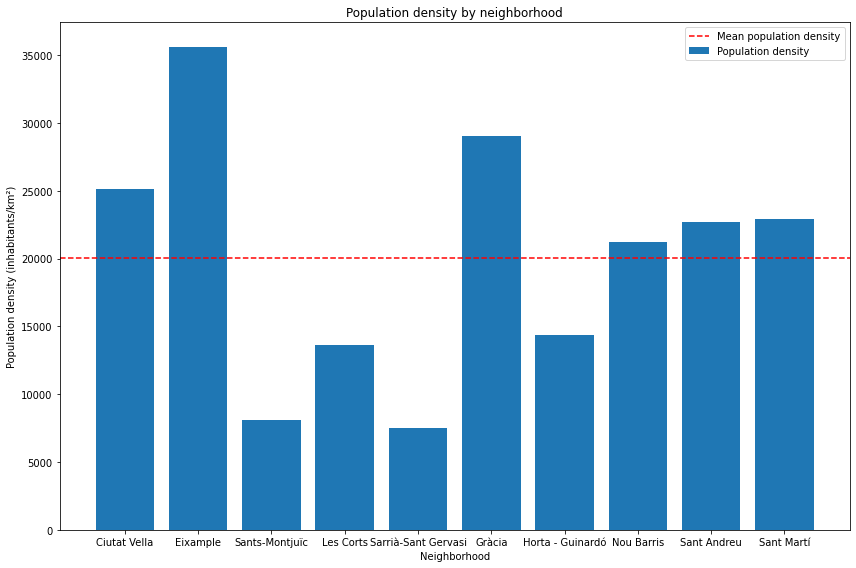

In [9]:
plt.rcParams["figure.figsize"] = (12,8)

fig, ax = plt.subplots()
rects1 = ax.bar(dfBCN['name'], dfBCN['pop_density'], label = 'Population density')

plt.axhline(y=dfBCN['pop_density'].mean(), color='r', linestyle='--', label = 'Mean population density')

ax.set_ylabel('Population density (inhabitants/km²)')
ax.set_xlabel('Neighborhood')
ax.set_title('Population density by neighborhood')
ax.set_xticklabels(dfBCN['name'])
ax.legend()

fig.tight_layout()

plt.show()

Let's take a look at the neighborhoods for **Barcelona**.

In [10]:
address = 'Barcelona, Spain'

geolocator = Nominatim(user_agent="bcn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_bcn = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(dfBCN['lat'], dfBCN['lon'], dfBCN['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  
    
map_bcn

Now let's get the venues for **Barcelona** using the **Foursquare API**

In [11]:
bcn_venues = getNearbyVenues(names=dfBCN['name'], latitudes=dfBCN['lat'], longitudes=dfBCN['lon'])
bcn_venues.head()

Ciutat Vella
Eixample
Sants-Montjuïc
Les Corts
Sarrià-Sant Gervasi
Gràcia
Horta - Guinardó
Nou Barris
Sant Andreu
Sant Martí


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ciutat Vella,41.374985,2.173277,The Fish & Chips Shop,41.375965,2.174152,Bistro
1,Ciutat Vella,41.374985,2.173277,macera,41.375589,2.170493,Cocktail Bar
2,Ciutat Vella,41.374985,2.173277,Cassette Bar,41.377324,2.173629,Bar
3,Ciutat Vella,41.374985,2.173277,Marea Alta,41.376484,2.175106,Seafood Restaurant
4,Ciutat Vella,41.374985,2.173277,Pizza Circus,41.377905,2.172911,Pizza Place


Let's get the venue types as columns and their frequencies for **Barcelona**

In [12]:
# one hot encoding
bcn_onehot = pd.get_dummies(bcn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bcn_onehot['Neighborhood'] = bcn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bcn_onehot.columns[-1]] + list(bcn_onehot.columns[:-1])
bcn_onehot = bcn_onehot[fixed_columns]

bcn_grouped = bcn_onehot.groupby('Neighborhood').mean().reset_index()
bcn_grouped['pop_density'] = bcn_grouped['Neighborhood'].apply(lambda x: dfBCN[dfBCN['name']==x]['pop_density'].values[0])

bcn_grouped.head()

,Neighborhood,Women's Store,Accessories Store,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Udon Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,pop_density
0,Ciutat Vella,0.00,0.00,0.0,0.0,0.017857,0.000000,0.035714,0.0000,0.000000,...,0.035714,0.000000,0.000000,0.053571,0.0,0.0,0.000000,0.0000,0.0000,25165.206813
1,Eixample,0.01,0.01,0.0,0.0,0.000000,0.010000,0.010000,0.0000,0.000000,...,0.050000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0000,35644.772118
2,Gràcia,0.00,0.00,0.0,0.0,0.000000,0.000000,0.012500,0.0125,0.012500,...,0.037500,0.012500,0.000000,0.012500,0.0,0.0,0.000000,0.0125,0.0125,29068.735084
3,Horta - Guinardó,0.00,0.00,0.0,0.0,0.000000,0.066667,0.000000,0.0000,0.000000,...,0.000000,0.066667,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0000,14339.046823
4,Les Corts,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.013333,...,0.013333,0.000000,0.013333,0.000000,0.0,0.0,0.026667,0.0000,0.0000,13616.943522


Let's the first 10 most common venues for **Barcelona**

In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bcn_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
bcn_neighborhoods_venues_sorted['Neighborhood'] = bcn_grouped['Neighborhood']

for index, row in bcn_grouped.iterrows():
    bcn_neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(row[[col for col in bcn_grouped.columns if col not in ['pop_density', 'Neighborhood']]], num_top_venues)

bcn_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciutat Vella,Boat or Ferry,Cocktail Bar,Bar,Hotel,Theater,Tapas Restaurant,Pizza Place,Plaza,Mediterranean Restaurant,Spanish Restaurant
1,Eixample,Hotel,Bakery,Boutique,Mediterranean Restaurant,Hostel,Tapas Restaurant,Restaurant,Spanish Restaurant,Bookstore,Cosmetics Shop
2,Gràcia,Bar,Sandwich Place,Mediterranean Restaurant,Café,Spanish Restaurant,Grocery Store,Supermarket,Restaurant,Tapas Restaurant,Park
3,Horta - Guinardó,Park,Chinese Restaurant,Plaza,Argentinian Restaurant,Soccer Field,Soccer Stadium,Farmers Market,Metro Station,Tennis Court,Outdoor Sculpture
4,Les Corts,Spanish Restaurant,Restaurant,Bakery,Café,Grocery Store,Hotel,Mediterranean Restaurant,Cocktail Bar,Supermarket,Sushi Restaurant


## Paris

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. 

Let's prepare the data for **Paris**.

In [14]:
dfParis = pd.read_csv('./data/paris_districts.csv')
dfParis['area'] = dfParis['area'].astype('float64')/1000
dfParis['population'] = dfParis['population'].apply(lambda x: float(re.sub(r"\s+", '', x)))
dfParis['pop_density'] = dfParis['population']/dfParis['area']
dfParis['coord'] = dfParis['name'].apply(lambda x: getNeighborhoodLatLon(x, 'Paris', 'France'))
dfParis['lat'] = dfParis['coord'].apply(lambda x: x[0])
dfParis['lon'] = dfParis['coord'].apply(lambda x: x[1])
dfParis.head()

,code,name,area,population,pop_density,coord,lat,lon
0,I distrito (D),Louvre,1.826,16888.0,9248.630887,"[48.8611473, 2.33802768704666]",48.861147,2.338028
1,II distrito (D),Bourse,0.992,19585.0,19742.943548,"[48.8686296, 2.3414739]",48.868630,2.341474
2,III distrito (D),Temple,1.171,34248.0,29246.797609,"[48.8665004, 2.360708]",48.866500,2.360708
3,IV distrito (D),Hôtel-de-Ville,1.601,30675.0,19159.900062,"[48.856426299999995, 2.3525275780116073]",48.856426,2.352528
4,V distrito (I),Panthéon,2.541,58849.0,23159.779614,"[48.84619085, 2.346078521905153]",48.846191,2.346079


Let's take a look at the population density by neighborhoods for **Paris**.

/home/dedsresende/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


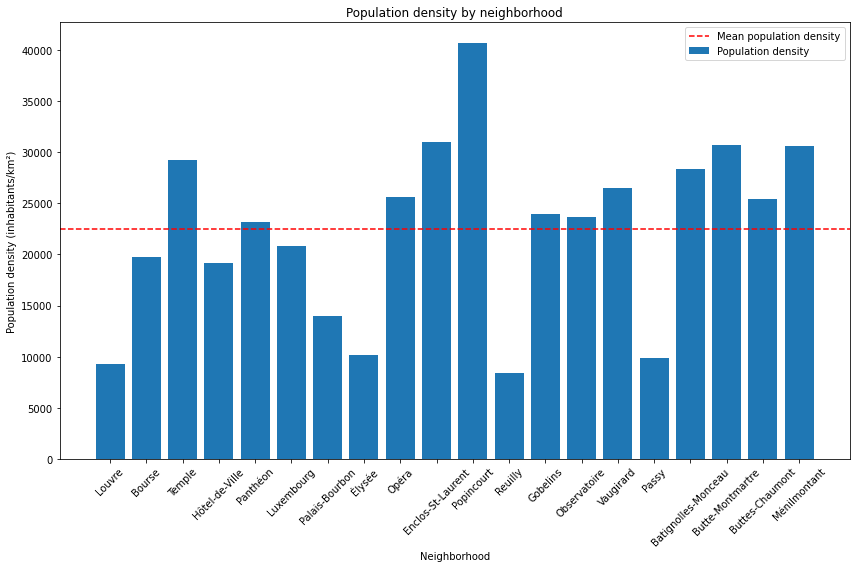

In [15]:
plt.rcParams["figure.figsize"] = (12,8)

fig, ax = plt.subplots()
rects1 = ax.bar(dfParis['name'], dfParis['pop_density'], label = 'Population density')

plt.axhline(y=dfParis['pop_density'].mean(), color='r', linestyle='--', label = 'Mean population density')

plt.xticks(rotation=45)

ax.set_ylabel('Population density (inhabitants/km²)')
ax.set_xlabel('Neighborhood')
ax.set_title('Population density by neighborhood')
ax.set_xticklabels(dfParis['name'])
ax.legend()

fig.tight_layout()

plt.show()

Let's take a look at the neighborhoods for **Paris**.

In [16]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_paris = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(dfParis['lat'], dfParis['lon'], dfParis['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

Now let's get the venues for **Paris** using the **Foursquare API**

In [17]:
paris_venues = getNearbyVenues(names=dfParis['name'], latitudes=dfParis['lat'], longitudes=dfParis['lon'])
paris_venues.head()

Louvre
Bourse
Temple
Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Élysée
Opéra
Enclos-St-Laurent
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Butte-Montmartre
Buttes-Chaumont
Ménilmontant


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Louvre,48.861147,2.338028,Musée du Louvre,48.860847,2.336440,Art Museum
1,Louvre,48.861147,2.338028,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza
2,Louvre,48.861147,2.338028,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
3,Louvre,48.861147,2.338028,Place du Palais Royal,48.862523,2.336688,Plaza
4,Louvre,48.861147,2.338028,Cour Napoléon,48.861172,2.335088,Plaza


Let's get the venue types as columns and their frequencies for **Paris**

In [18]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()

paris_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Batignolles-Monceau,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.019231,0.0,0.019231,...,0.0,0.0,0.00000,0.019231,0.00,0.000000,0.0,0.019231,0.019231,0.00
1,Bourse,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.010000,...,0.0,0.0,0.00000,0.000000,0.01,0.000000,0.0,0.070000,0.010000,0.02
2,Butte-Montmartre,0.0,0.00000,0.0,0.0,0.014706,0.014706,0.000000,0.0,0.014706,...,0.0,0.0,0.00000,0.000000,0.00,0.014706,0.0,0.014706,0.000000,0.00
3,Buttes-Chaumont,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.027027,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.00,0.000000,0.0,0.027027,0.000000,0.00
4,Enclos-St-Laurent,0.0,0.02439,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.02439,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00


Let's keep only the venue types in **Paris** that are also in **Barcelona**. To make sure the data nmodels have the same shape.

In [19]:
grouped_columns = list(set(bcn_grouped.columns.tolist()+paris_grouped.columns.tolist()))
grouped_columns = [col for col in grouped_columns if col in bcn_grouped.columns and col in paris_grouped.columns]
paris_grouped = paris_grouped[grouped_columns]
paris_grouped['pop_density'] = paris_grouped['Neighborhood'].apply(lambda x: dfParis[dfParis['name']==x]['pop_density'].values[0])

bcn_grouped = bcn_grouped[grouped_columns]
bcn_grouped['pop_density'] = bcn_grouped['Neighborhood'].apply(lambda x: dfBCN[dfBCN['name']==x]['pop_density'].values[0])

print(paris_grouped.shape, bcn_grouped.shape)

(20, 107) (10, 107)


Let's the first 10 most common venues for **Paris**

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
paris_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
paris_neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for index, row in paris_grouped.iterrows():
    paris_neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(row[[col for col in paris_grouped.columns if col not in ['pop_density', 'Neighborhood']]], num_top_venues)

paris_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,Italian Restaurant,Thai Restaurant,Korean Restaurant,Bakery,Restaurant,Farmers Market,Asian Restaurant,Convenience Store,Japanese Restaurant,Indian Restaurant
1,Bourse,Wine Bar,Hotel,Cocktail Bar,Japanese Restaurant,Bistro,Clothing Store,Bakery,Italian Restaurant,Concert Hall,Coffee Shop
2,Butte-Montmartre,Bar,Italian Restaurant,Pizza Place,Park,Bistro,Sandwich Place,Convenience Store,Café,Japanese Restaurant,Plaza
3,Buttes-Chaumont,Pool,Restaurant,Park,Italian Restaurant,Plaza,Hotel,Scenic Lookout,Coffee Shop,Japanese Restaurant,Art Museum
4,Enclos-St-Laurent,Hotel,Plaza,Sandwich Place,Sushi Restaurant,Italian Restaurant,Bistro,Indian Restaurant,Café,Dessert Shop,Pizza Place


## Methodology <a name="methodology"></a>

Using the data of districts of Barcelona and Paris from *Wikipedia* and the Foursquare API data, the idea is to Cluster Barcelona Districts and fit the districts of Paris in the same model finding similar clusters. Once all districts are labeled understand which one offers the best balance between activities diversity and population density among them.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **top 5 venue types for Barcelona and Paris**:

In [21]:
num_top_venues = 5

print('---------- Barcelona ----------')

for hood in bcn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bcn_grouped[bcn_grouped['Neighborhood'] == hood][[col for col in bcn_grouped.columns if col not in ['pop_density', 'Neighborhood']]].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
print('---------- Paris ----------')

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood][[col for col in paris_grouped.columns if col not in ['pop_density', 'Neighborhood']]].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---------- Barcelona ----------
----Ciutat Vella----
           venue  freq
0  Boat or Ferry  0.09
1   Cocktail Bar  0.09
2            Bar  0.07
3          Hotel  0.05
4        Theater  0.05


----Eixample----
                      venue  freq
0                     Hotel  0.12
1                    Bakery  0.06
2                  Boutique  0.05
3  Mediterranean Restaurant  0.05
4          Tapas Restaurant  0.05


----Gràcia----
                      venue  freq
0                       Bar  0.12
1                      Café  0.05
2        Spanish Restaurant  0.05
3            Sandwich Place  0.05
4  Mediterranean Restaurant  0.05


----Horta - Guinardó----
                    venue  freq
0                    Park  0.13
1      Spanish Restaurant  0.07
2      Chinese Restaurant  0.07
3           Metro Station  0.07
4  Argentinian Restaurant  0.07


----Les Corts----
                venue  freq
0  Spanish Restaurant  0.08
1          Restaurant  0.07
2              Bakery  0.07
3             

## Clustering the neighborhoods

### Training the model with Barcelona data

In [22]:
bcn_grouped_clustering = bcn_grouped.drop('Neighborhood', 1)

# set number of clusters
kclusters = 5

# Standardizes population density values
scaler = StandardScaler()
bcn_grouped_clustering['pop_density'] = scaler.fit_transform(bcn_grouped_clustering[['pop_density']])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0)
kmeans.fit(bcn_grouped_clustering)
# assigning the cluster labels to Barcelona dataframe
dfBCN['cluster_label'] = kmeans.labels_
dfBCN.head()

,code,name,area,population,pop_density,coord,lat,lon,cluster_label
0,1,Ciutat Vella,4.11,103429.0,25165.206813,"[41.3749846, 2.17327724224704]",41.374985,2.173277,2
1,2,Eixample,7.46,265910.0,35644.772118,"[41.3936885, 2.1636552]",41.393689,2.163655,4
2,3,Sants-Montjuïc,22.68,184091.0,8116.887125,"[41.3647625, 2.154233]",41.364762,2.154233,1
3,4,Les Corts,6.02,81974.0,13616.943522,"[41.385244, 2.1328626]",41.385244,2.132863,0
4,5,Sarrià-Sant Gervasi,19.91,149260.0,7496.735309,"[41.413038650000004, 2.1076199588346816]",41.413039,2.107620,0


### Barcelona clustering map

In [23]:
address = 'Barcelona, Spain'

geolocator = Nominatim(user_agent="bcn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfBCN['lat'], dfBCN['lon'], dfBCN['name'], dfBCN['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters in Barceloa

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [24]:
# Addning labels and population density to Barcelona dataframe
bcn_neighborhoods_venues_sorted['cluster_label'] = dfBCN['cluster_label']
bcn_neighborhoods_venues_sorted['pop_density'] = dfBCN['pop_density']

Let's take a look at the mean population density by cluesters for **Barcelona**.

/home/dedsresende/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


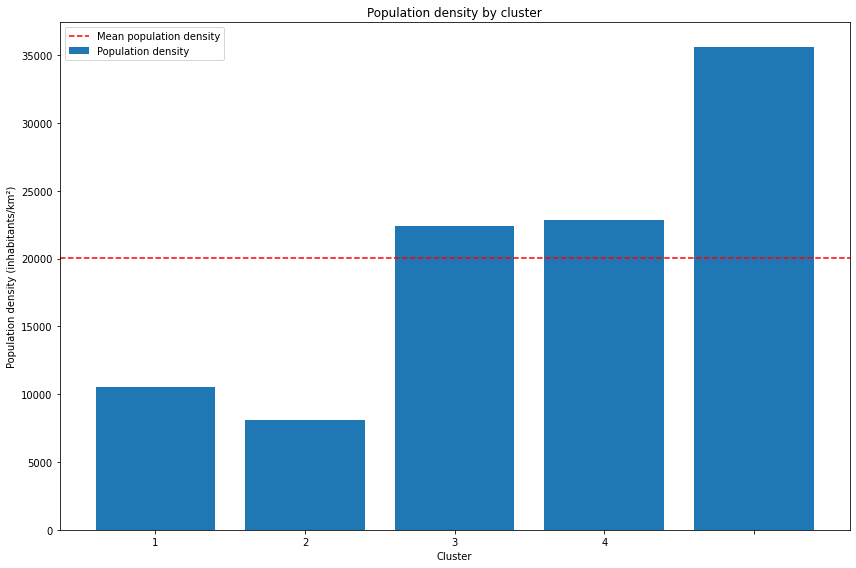

In [25]:
plt.rcParams["figure.figsize"] = (12,8)

bcn_pop_density_cluster = bcn_neighborhoods_venues_sorted.groupby('cluster_label')['pop_density'].mean().reset_index()

fig, ax = plt.subplots()
rects1 = ax.bar(bcn_pop_density_cluster['cluster_label'], bcn_pop_density_cluster['pop_density'], label = 'Population density')

plt.axhline(y=dfBCN['pop_density'].mean(), color='r', linestyle='--', label = 'Mean population density')

ax.set_ylabel('Population density (inhabitants/km²)')
ax.set_xlabel('Cluster')
ax.set_title('Population density by cluster')
ax.set_xticklabels(bcn_pop_density_cluster['cluster_label'])
ax.legend()

fig.tight_layout()

plt.show()

#### Cluster 0

In [26]:
bcn_neighborhoods_venues_sorted[bcn_neighborhoods_venues_sorted['cluster_label']==0][[col for col in bcn_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
3,Horta - Guinardó,Park,Chinese Restaurant,Plaza,Argentinian Restaurant,Soccer Field,Soccer Stadium,Farmers Market,Metro Station,Tennis Court,Outdoor Sculpture,13616.943522
4,Les Corts,Spanish Restaurant,Restaurant,Bakery,Café,Grocery Store,Hotel,Mediterranean Restaurant,Cocktail Bar,Supermarket,Sushi Restaurant,7496.735309


#### Cluster 1

In [27]:
bcn_neighborhoods_venues_sorted[bcn_neighborhoods_venues_sorted['cluster_label']==1][[col for col in bcn_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
2,Gràcia,Bar,Sandwich Place,Mediterranean Restaurant,Café,Spanish Restaurant,Grocery Store,Supermarket,Restaurant,Tapas Restaurant,Park,8116.887125


#### Cluster 2

In [28]:
bcn_neighborhoods_venues_sorted[bcn_neighborhoods_venues_sorted['cluster_label']==2][[col for col in bcn_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
0,Ciutat Vella,Boat or Ferry,Cocktail Bar,Bar,Hotel,Theater,Tapas Restaurant,Pizza Place,Plaza,Mediterranean Restaurant,Spanish Restaurant,25165.206813
5,Nou Barris,Spanish Restaurant,Grocery Store,Park,Italian Restaurant,Music Venue,Pizza Place,Sports Club,Supermarket,Building,Bar,29068.735084
6,Sant Andreu,Clothing Store,Burger Joint,Spanish Restaurant,Tapas Restaurant,Italian Restaurant,Sandwich Place,Cosmetics Shop,Fast Food Restaurant,Electronics Store,Sporting Goods Shop,14339.046823
7,Sant Martí,Mediterranean Restaurant,Pizza Place,Indian Restaurant,Bakery,Italian Restaurant,Breakfast Spot,Hotel,Gym / Fitness Center,Park,Performing Arts Venue,21201.118012


#### Cluster 3

In [29]:
bcn_neighborhoods_venues_sorted[bcn_neighborhoods_venues_sorted['cluster_label']==3][[col for col in bcn_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
8,Sants-Montjuïc,Garden,Park,Scenic Lookout,Museum,Stadium,Plaza,Café,Skate Park,Palace,Cocktail Bar,22734.597876
9,Sarrià-Sant Gervasi,Light Rail Station,Plaza,Ice Cream Shop,Convenience Store,National Park,Building,BBQ Joint,Farmers Market,Pedestrian Plaza,Paella Restaurant,22936.958614


#### Cluster 4

In [30]:
bcn_neighborhoods_venues_sorted[bcn_neighborhoods_venues_sorted['cluster_label']==4][[col for col in bcn_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
1,Eixample,Hotel,Bakery,Boutique,Mediterranean Restaurant,Hostel,Tapas Restaurant,Restaurant,Spanish Restaurant,Bookstore,Cosmetics Shop,35644.772118


## Clustering Paris

In [31]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# Standardizes population density values
scaler = StandardScaler()
paris_grouped_clustering['pop_density'] = scaler.fit_transform(paris_grouped_clustering[['pop_density']])

# assigning the cluster labels to Paris dataframe
dfParis['cluster_label'] = kmeans.predict(paris_grouped_clustering)

dfParis.head()

,code,name,area,population,pop_density,coord,lat,lon,cluster_label
0,I distrito (D),Louvre,1.826,16888.0,9248.630887,"[48.8611473, 2.33802768704666]",48.861147,2.338028,2
1,II distrito (D),Bourse,0.992,19585.0,19742.943548,"[48.8686296, 2.3414739]",48.868630,2.341474,0
2,III distrito (D),Temple,1.171,34248.0,29246.797609,"[48.8665004, 2.360708]",48.866500,2.360708,1
3,IV distrito (D),Hôtel-de-Ville,1.601,30675.0,19159.900062,"[48.856426299999995, 2.3525275780116073]",48.856426,2.352528,2
4,V distrito (I),Panthéon,2.541,58849.0,23159.779614,"[48.84619085, 2.346078521905153]",48.846191,2.346079,1


### Paris clustering map

In [32]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfParis['lat'], dfParis['lon'], dfParis['name'], dfParis['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters in Paris

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [33]:
# Addning labels and population density to Barcelona dataframe
paris_neighborhoods_venues_sorted['cluster_label'] = dfParis['cluster_label']
paris_neighborhoods_venues_sorted['pop_density'] = dfParis['pop_density']

Let's take a look at the mean population density by cluesters for **Paris**.

/home/dedsresende/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


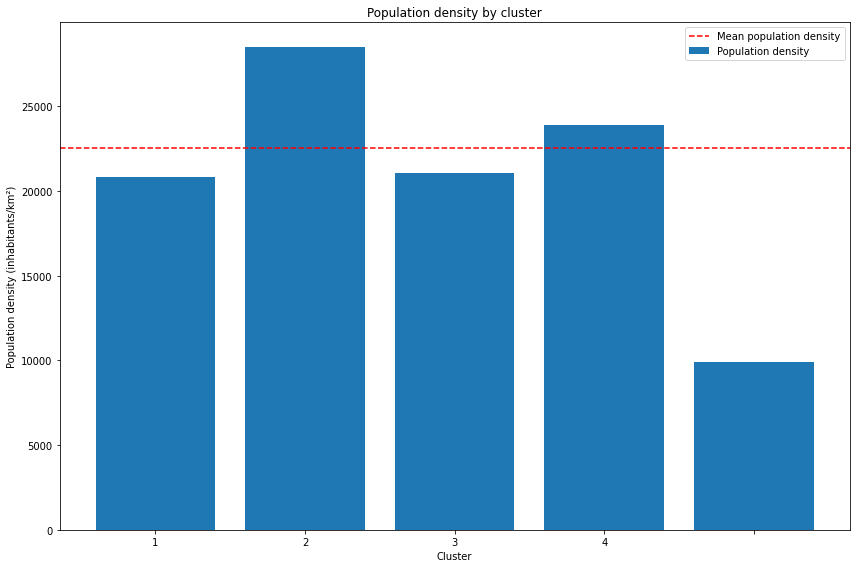

In [34]:
plt.rcParams["figure.figsize"] = (12,8)

paris_pop_density_cluster = paris_neighborhoods_venues_sorted.groupby('cluster_label')['pop_density'].mean().reset_index()

fig, ax = plt.subplots()
rects1 = ax.bar(paris_pop_density_cluster['cluster_label'], paris_pop_density_cluster['pop_density'], label = 'Population density')

plt.axhline(y=dfParis['pop_density'].mean(), color='r', linestyle='--', label = 'Mean population density')

ax.set_ylabel('Population density (inhabitants/km²)')
ax.set_xlabel('Cluster')
ax.set_title('Population density by cluster')
ax.set_xticklabels(paris_pop_density_cluster['cluster_label'])
ax.legend()

fig.tight_layout()

plt.show()

#### Cluster 0

In [35]:
paris_neighborhoods_venues_sorted[paris_neighborhoods_venues_sorted['cluster_label']==0][[col for col in paris_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
1,Bourse,Wine Bar,Hotel,Cocktail Bar,Japanese Restaurant,Bistro,Clothing Store,Bakery,Italian Restaurant,Concert Hall,Coffee Shop,19742.943548
6,Hôtel-de-Ville,Ice Cream Shop,Plaza,Clothing Store,Art Gallery,Coffee Shop,Gay Bar,Wine Bar,Park,Bookstore,Pedestrian Plaza,13939.579256
8,Luxembourg,Plaza,Chocolate Shop,American Restaurant,Seafood Restaurant,Italian Restaurant,Wine Bar,Café,Cocktail Bar,Hotel,Shopping Mall,25625.516292
12,Palais-Bourbon,Plaza,Hotel,Pedestrian Plaza,Italian Restaurant,Bistro,Art Museum,Bakery,Café,Coffee Shop,Asian Restaurant,24004.058214


#### Cluster 1

In [36]:
paris_neighborhoods_venues_sorted[paris_neighborhoods_venues_sorted['cluster_label']==1][[col for col in paris_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
2,Butte-Montmartre,Bar,Italian Restaurant,Pizza Place,Park,Bistro,Sandwich Place,Convenience Store,Café,Japanese Restaurant,Plaza,29246.797609
4,Enclos-St-Laurent,Hotel,Plaza,Sandwich Place,Sushi Restaurant,Italian Restaurant,Bistro,Indian Restaurant,Café,Dessert Shop,Pizza Place,23159.779614
9,Ménilmontant,Bar,Pizza Place,Cocktail Bar,Italian Restaurant,Beer Bar,Brewery,Burger Joint,Hotel,Restaurant,Rock Club,30986.168741
17,Temple,Hotel,Wine Bar,Bar,Bakery,Cocktail Bar,Art Gallery,Italian Restaurant,Sandwich Place,Restaurant,Chinese Restaurant,30738.717735


#### Cluster 2

In [37]:
paris_neighborhoods_venues_sorted[paris_neighborhoods_venues_sorted['cluster_label']==2][[col for col in paris_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
0,Batignolles-Monceau,Italian Restaurant,Thai Restaurant,Korean Restaurant,Bakery,Restaurant,Farmers Market,Asian Restaurant,Convenience Store,Japanese Restaurant,Indian Restaurant,9248.630887
3,Buttes-Chaumont,Pool,Restaurant,Park,Italian Restaurant,Plaza,Hotel,Scenic Lookout,Coffee Shop,Japanese Restaurant,Art Museum,19159.900062
5,Gobelins,Hotel,Thai Restaurant,Indian Restaurant,Italian Restaurant,Bar,Bakery,Café,Chinese Restaurant,Mexican Restaurant,Asian Restaurant,20853.760446
10,Observatoire,Hotel,Café,Italian Restaurant,Sushi Restaurant,Pizza Place,Grocery Store,Fast Food Restaurant,Bakery,Roof Deck,Shopping Mall,40671.576650
11,Opéra,Hotel,Japanese Restaurant,Italian Restaurant,Sandwich Place,Chocolate Shop,Concert Hall,Coffee Shop,Plaza,Salad Place,Gourmet Shop,8367.495712
13,Panthéon,Bar,Hotel,Italian Restaurant,Café,Pub,Ice Cream Shop,Bakery,Plaza,Burger Joint,Wine Bar,23633.517168
18,Vaugirard,Italian Restaurant,Hotel,Supermarket,Japanese Restaurant,Bar,Coffee Shop,Russian Restaurant,Indian Restaurant,Park,Thai Restaurant,25453.875626


#### Cluster 3

In [38]:
paris_neighborhoods_venues_sorted[paris_neighborhoods_venues_sorted['cluster_label']==3][[col for col in paris_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
7,Louvre,Plaza,Italian Restaurant,Hotel,Art Museum,Coffee Shop,Clothing Store,Historic Site,Garden,Cosmetics Shop,Sandwich Place,10129.863437
14,Passy,Hotel,Japanese Restaurant,Italian Restaurant,Plaza,Bakery,Chinese Restaurant,Thai Restaurant,Clothing Store,Supermarket,Seafood Restaurant,26506.939544
16,Reuilly,Hotel,Bistro,Supermarket,Bakery,Sushi Restaurant,Pizza Place,Ice Cream Shop,Optical Shop,Chinese Restaurant,Plaza,28375.374846
19,Élysée,Hotel,Sandwich Place,Bakery,Cocktail Bar,Plaza,Coffee Shop,Park,Nightclub,Boat or Ferry,Convenience Store,30573.529412


#### Cluster 4

In [39]:
paris_neighborhoods_venues_sorted[paris_neighborhoods_venues_sorted['cluster_label']==4][[col for col in paris_neighborhoods_venues_sorted.columns if col != 'cluster_label']]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,pop_density
15,Popincourt,Bar,Cocktail Bar,Italian Restaurant,Café,Bakery,Bistro,Restaurant,Japanese Restaurant,Theater,Vegetarian / Vegan Restaurant,9921.680466


## Results and Discussion <a name="results"></a>

The challenge of the proposed work was to divide neighborhoods in different cities into clusters based on the presence of types of trade and their population density.

As a model, the city of **Barcelona in Spain** was used and for that 105 types of venus coming from the foursquare API plus its population density (number of inhabitants per square kilometer).

The city was then divided into **5 clusters**:
### Cluster 0
**With a high density (the highest among clusters), neighborhoods on the outskirts of the city and local shops with a large presence of bakeries, local restaurants and markets;**
### Cluster 1
**With a very low density, and a neighborhood with many bars and cafes;**
### Cluster 2
**The lowest average density in the city and a cluster with very different activities among shops of different types, bars and restaurants. It is the cluster in which Ciutat Vellase was classified;**
### Cluster 3
**The average density close to the city and with very diverse activities mainly related to parks and squares;**
### Cluster 4
**A cluster very similar to cluster 2, however, with a population density closer to the city average;**

This model was applied to **Paris in France**, and the main thing to note is that as **Paris** has a higher average density than **Barcelona**, this attribute was not relevant for the division into clusters, showing how **cluster 2** for example in the case of **Paris** has a density much higher population than in **Barcelona**.

## Conclusion <a name="conclusion"></a>

In conclusion, according to the classification by clusters, the best option would be to try to move to one of the neighborhoods in **cluster 2**, and as previously said, besides the search for a great diversity of activities, a scale with a lower population density would also be interesting two main options would be the **Opera and Batignolles-Monceau** neighborhoods. 

But finally getting to know the city of **Paris**, and following the map of the lusters, the **Opera** neighborhood is much more similar to the **Ciudad Vella** district because it is located in a more central region.

Knowing the two cities, **Barcelona and Paris**, it can be seen that clustering through the presence of commercial activities has an interesting precision despite the fact that the population density acts in very different ways in both cities.